![](img/logo.png)

# Machine learning with Scikit-learn
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import zipfile

import sklearn.datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

# Supervised learning

Supervised learning consists in learning the link between two datasets: the observed data `X` and an external variable `y` that we are trying to predict, usually called “target” or “labels”. Most often, `y` is a 1D array of length `n_samples`.

All supervised estimators in *scikit-learn* implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

There are two fundamental supervised learning problems: regression and classification.
In regression, we need to predict a number.
In classification, we need to predict a (discrete) class.

We will now deal with regression, in which $Y$ can be any continous value.

# Tennis: predict points from aces

Let's download some tennis data so that we can talk about *linear regression*.

This data is from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.

We open the containing zip file and print its contents.

Note: [`zipfile`](https://docs.python.org/3/library/zipfile.html) is part of Python standard library, which also includes modules for [`gzip`](https://docs.python.org/3/library/gzip.html), [`bz2`](https://docs.python.org/3/library/bz2.html) and other compression formats.

In [50]:
filename = '../data/tennis.zip'

tennis_zip = zipfile.ZipFile(filename)
for f in tennis_zip.filelist: 
    print(f.filename)

data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


We open the data for Novak Djokovic.

In [51]:
player = 'Novak Djokovic'
path = 'data/{}.csv'
path = path.format(player.replace(' ', '-'))
with tennis_zip.open(path) as f:
    df = pd.read_csv(f)
df.tail()

year                  tournament  start date type        surface  \
725  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
726  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
727  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
728  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
729  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   

          draw atp points  atp ranking tournament prize money round  ...  \
725  Draw: 128      2,000          1.0            A$2,300,000   R32  ...   
726  Draw: 128      2,000          1.0            A$2,300,000   R16  ...   
727  Draw: 128      2,000          1.0            A$2,300,000     Q  ...   
728  Draw: 128      2,000          1.0            A$2,300,000     S  ...   
729  Draw: 128      2,000          1.0            A$2,300,000     W  ...   

    player2 2nd serve return points total player2 break points converted won  \
725                                  20.0                                0.0   
726                                  39.0                                4.0   
727                                  44.0                                2.0   
728                                  67.0                                7.0   
729                                  68.0                                4.0   

    player2 break points converted total player2 return games played  \
725                                  1.0                        10.0   
726                                  6.0                        18.0   
727                                  4.0                        15.0   
728                                 24.0                        24.0   
729                                  6.0                        27.0   

    player2 total service points won player2 total service points total  \
725                             26.0                               66.0   
726                             66.0                              124.0   
727                             56.0                               98.0   
728                             89.0                              174.0   
729                            120.0                              203.0   

     player2 total return points won player2 total return points total  \
725                             11.0                              52.0   
726                             34.0                             102.0   
727                             28.0                              91.0   
728                             72.0                             171.0   
729                             56.0                             166.0   

    player2 total points won player2 total points total  
725                     37.0                      118.0  
726                    100.0                      226.0  
727                     84.0                      189.0  
728                    161.0                      345.0  
729                    176.0                      369.0  

[5 rows x 70 columns]

We plot a scatterplot of aces and total points won, together with the distributions of each. the distributions seem smooth and the scatterplot does show a clear slope.

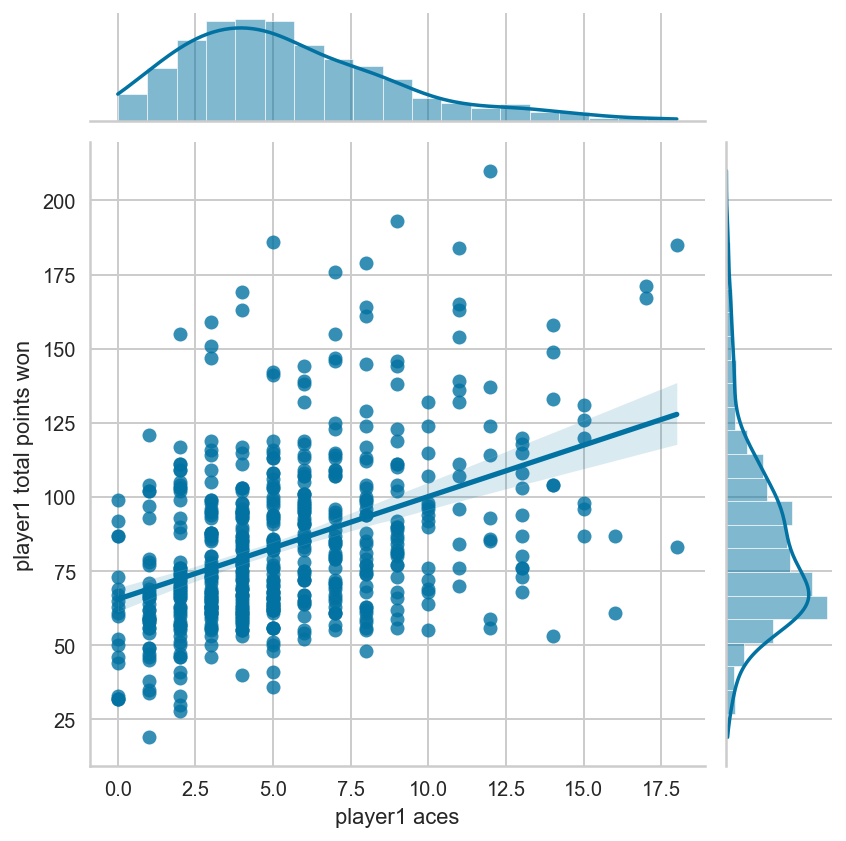

In [52]:
sns.jointplot(x='player1 aces', y='player1 total points won', data=df, kind='reg');

The simplest model for such predictions is the linear model
$$
\widehat{y} = ax + b
$$
where here $x$ is the aces and $y$ is the points won.
The model parameters can be interpreted as follows:
- the intercept $b$ is the estimate for points won if 0 points were aced, and
- the slope $a$ is the estimate for the linear increase in points won for every additional ace.

We then look for $a$ and $b$ such that this loss function is minimized:
$$
loss = \sum_{i=1}^n{(y-\widehat{y})^2}
$$
Note that this loss is just the square of the residuals -- the difference between the true value $y$ and the predicted value $\widehat{y}$.

Let's use Scikit-learn to fit a linear regression model.

We import the model, and format the data the way scikit-learn likes it.

In [53]:
from sklearn import linear_model

In [54]:
X = df['player1 aces'].values
y = df['player1 total points won'].values
# remove NaN
y = y[np.isfinite(X)]
X = X[np.isfinite(X)]
# scikit-learn likes X to be 2D, even if there is only one feature
X = X.reshape((-1, 1)) 
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We then fit the model.

In [55]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
print("R^2: {:.4f}".format(lm.score(X_test, y_test)))

R^2: 0.0672


$R^2$ is the proportion of variation in $y$ explained by the linear regression. 6% is not a lot...

However, the plot looks pretty good.

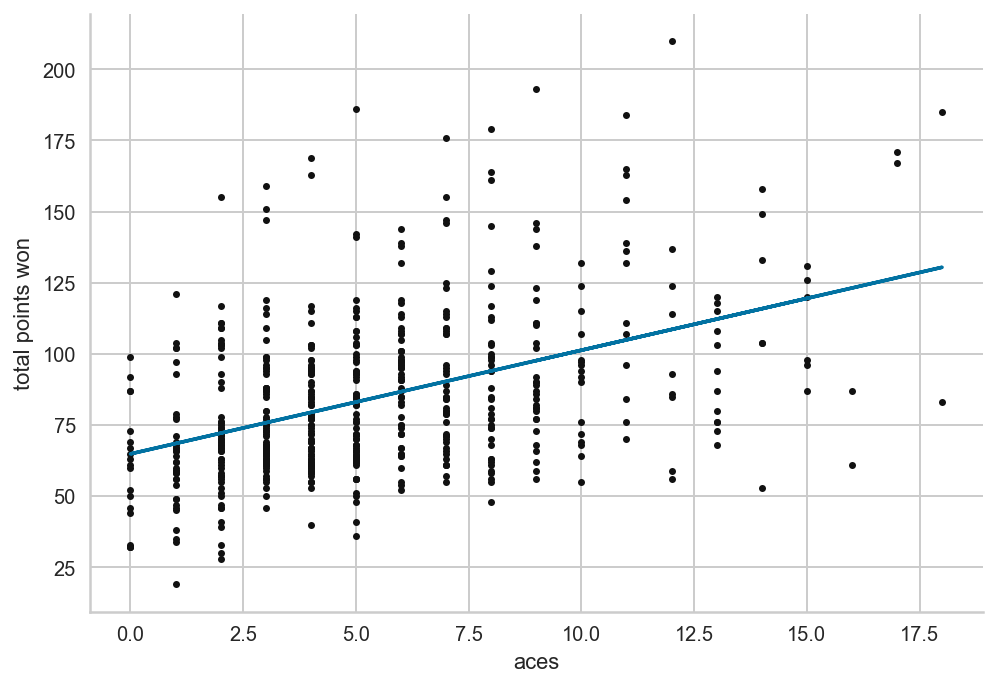

In [56]:
plt.plot(X, y, '.k')
plt.plot(X, lm.predict(X))
plt.xlabel('aces')
plt.ylabel('total points won')
sns.despine()

## Robust linear regression

There are many outliers in the data - points far away to the top.

We can try a linear regression model that is robust to outliers.
One example is Huber regression.

In [57]:
hub = linear_model.HuberRegressor()
hub.fit(X_train, y_train)
print("R^2: {:.4f}".format(hub.score(X_test, y_test)))

R^2: 0.0723


The $R^2$ is slightly higher.

What about the line? Let's compare to the standard linear model.

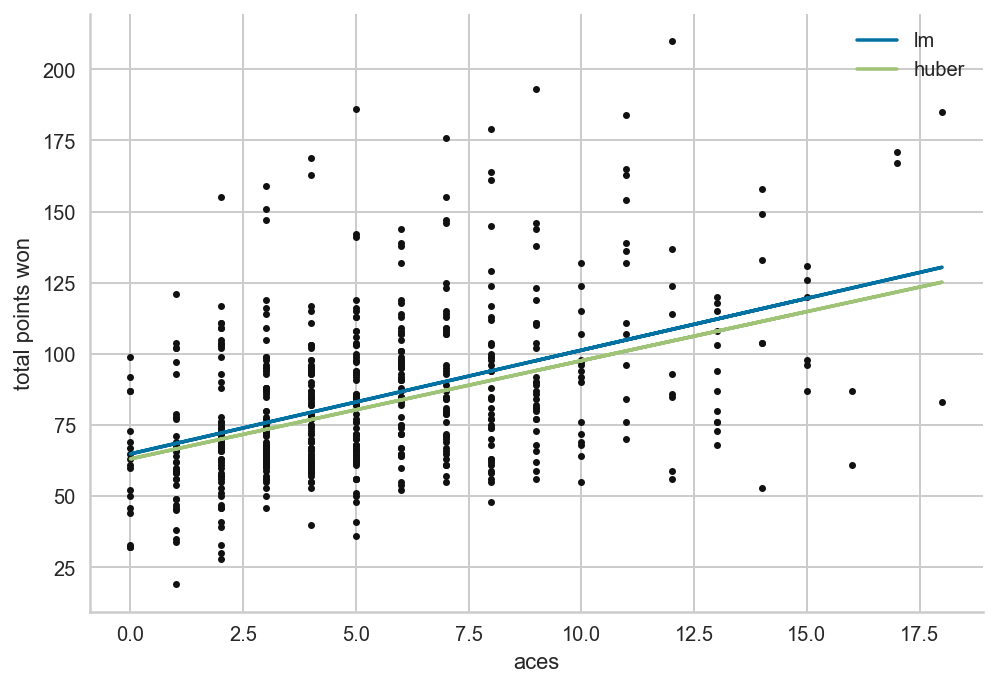

In [58]:
plt.plot(X, y, '.k')
plt.plot(X, lm.predict(X), label='lm')
plt.plot(X, hub.predict(X), label='huber')
plt.xlabel('aces')
plt.ylabel('total points won')
plt.legend()
sns.despine()

You can see that the Huber model is slightly less affected by the high-total matches.

## Exercise: Tennis

Try to choose a different feature that explains the total points won.

# Diabetes: multiple features

Now we try to predict a continuous variable $y$ 

We'll work with the diabetes dataset:
> Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

In [31]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
feature_names = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
n_features = len(feature_names)

df = pd.DataFrame(data=X, columns=feature_names)
df['target'] = y
df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019908 -0.017646   151.0  
1 -0.039493 -0.068330 -0.092204    75.0  
2 -0.002592  0.002864 -0.025930   141.0  
3  0.034309  0.022692 -0.009362   206.0  
4 -0.002592 -0.031991 -0.046641   135.0

Let's look at the features (`X`):

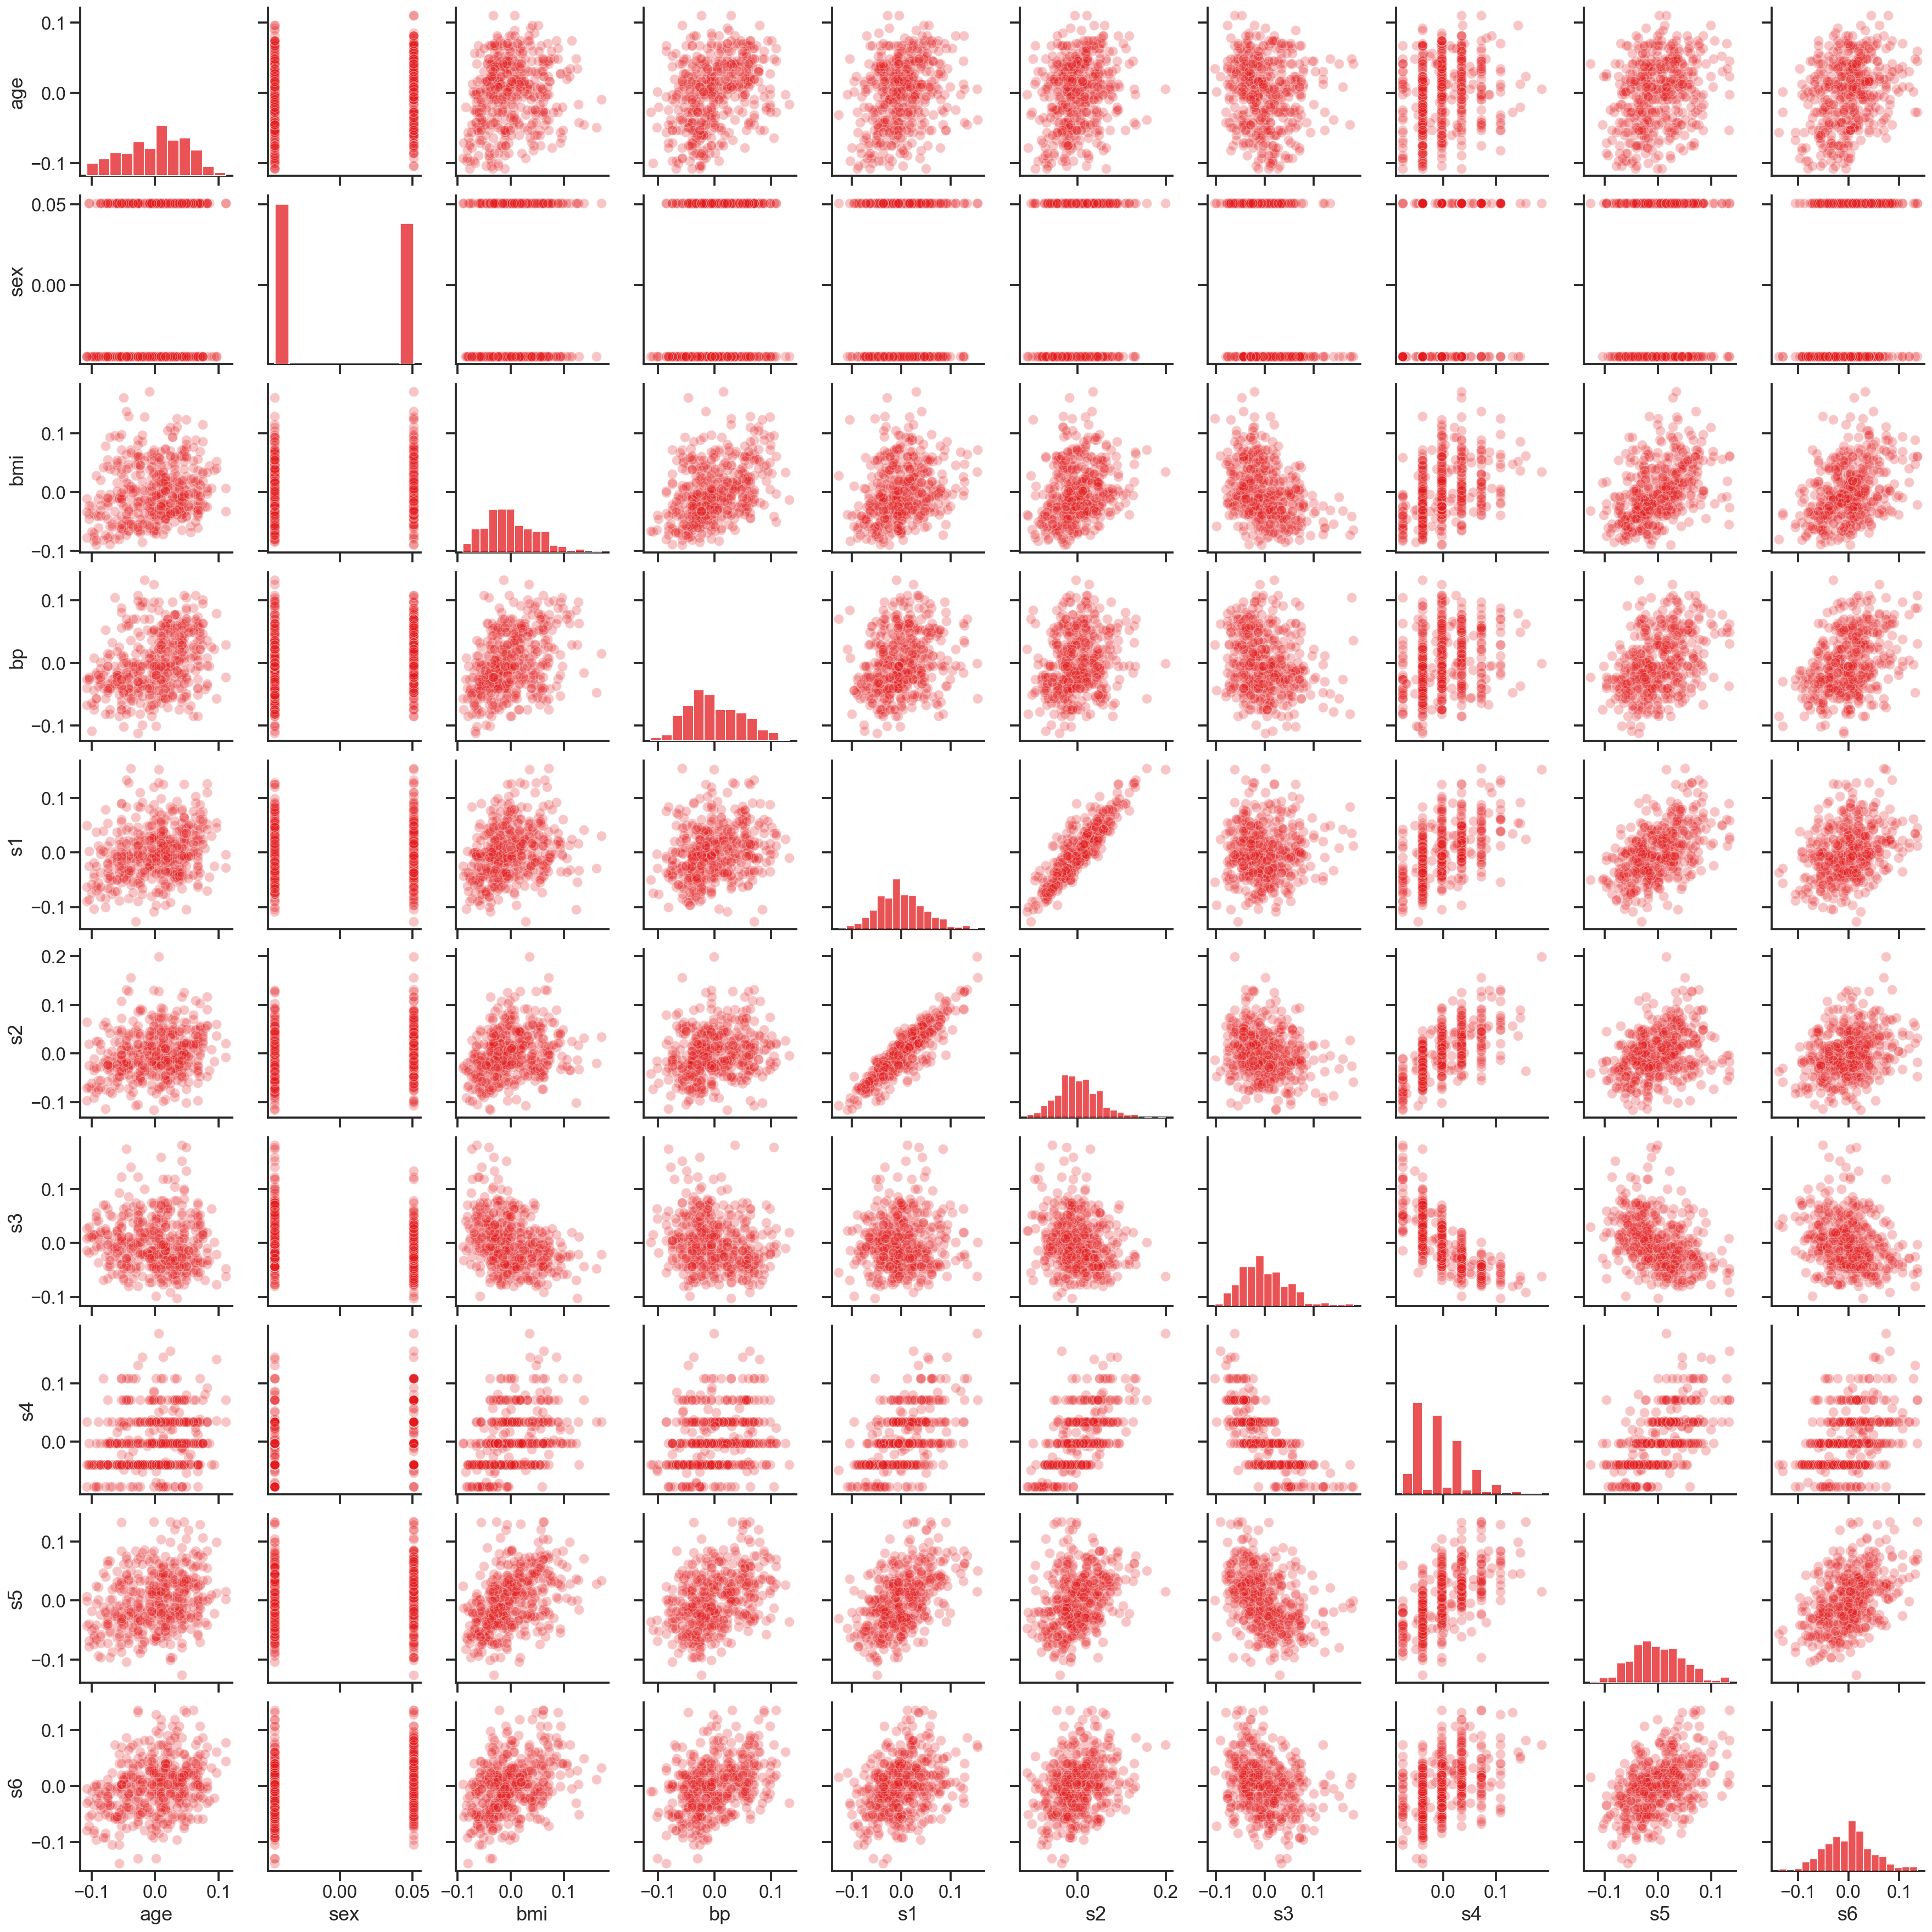

In [12]:
sns.pairplot(df, vars=features, plot_kws=dict(alpha=0.25));

Let's look at the distribution of the targets (`y`):

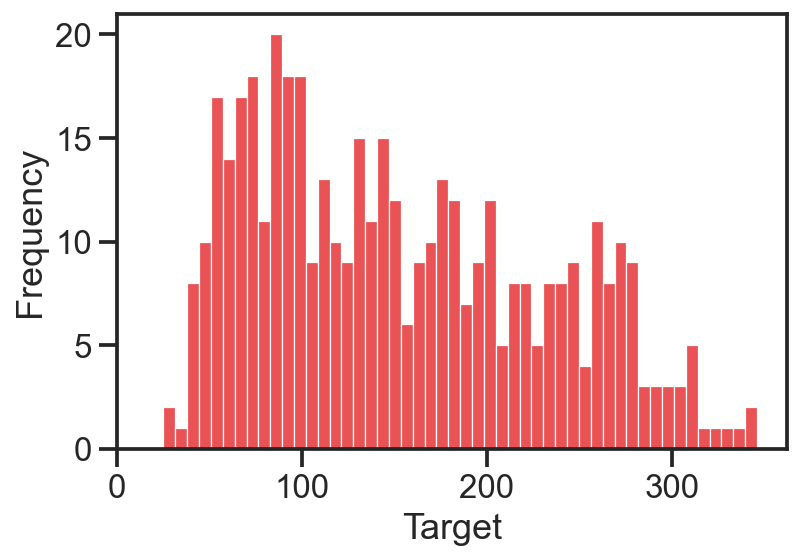

In [13]:
sns.histplot(y, bins=50)
plt.xlim(0, None);
plt.xlabel('Target')
plt.ylabel('Frequency');

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
n_features = len(feature_names)

Let's use a linear model to do regression.

We assume that $y$ is a linear function of $x$:

$$ \hat{y} = a_0 + a_1 x_1 + \ldots + a_m x_m $$

We use scikit-learn to find $a_j$ such that the model fit is optimal, that is, the following function is minimized:

$$
f(a_1, \ldots, a_m) = \frac{1}{n} \sum_{i=1}^{n}{(\hat{y}_i - y_i)^2}
$$
where $i$ is the i-th sample out of $n$ samples.

Lets run the regression and print the model score, which is the $R^2$ -- the fraction of variance in the target explained by the model.

In [33]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)
y_hat = regressor.predict(X_test)
score = regressor.score(X_test, y_test)
print('Linear model score: {:.2f}'.format(score))

Linear model score: 0.36


## Diagnostic plots

How good is the model? We can use [yellowbrick](https://www.scikit-yb.org/en/latest/gallery.html) to plot two diagnostic plots:
- a **residual plot** shows the residual ($\hat{y}-y$) distribution. Zero residuals are good, and we expect a normal distribution around zero.
- a **prediction error plot** shows the $\hat{y}$ vs $y$ together with a one-to-one line. We would like the markers to be close to the line and the cloud of markers to be roughly symmetric around the line.

In [35]:
from yellowbrick.regressor import ResidualsPlot, PredictionError

R^2=0.3594


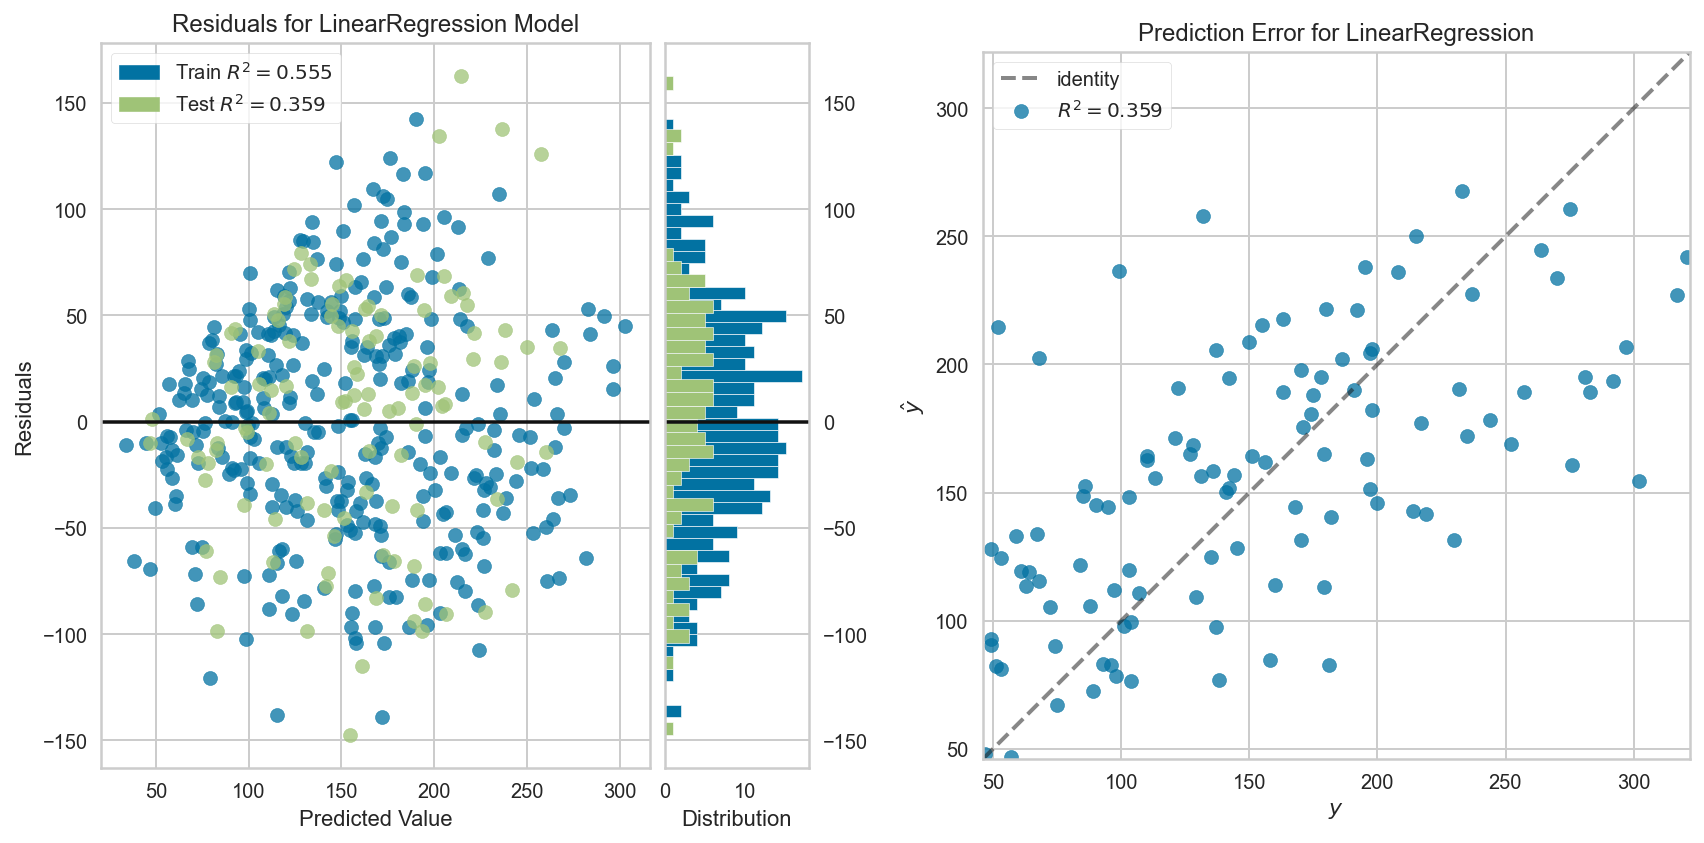

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

viz = ResidualsPlot(regressor, is_fitted=True, ax=axes[0])
viz.fit(X_train, y_train) # blue markers
R2 = viz.score(X_test, y_test) # green markers
viz.finalize() # adds the lines
print("R^2={:.4f}".format(R2))

viz = PredictionError(regressor, is_fitted=True, line_color='k', bestfit=False, ax=axes[1])
# viz.fit(X_train, y_train) # not needed here
viz.score(X_test, y_test) 
viz.finalize() # adds the line

fig.tight_layout()

One of the advantages of a linear model is that we can interpret the coefficients as the contribution of the features to the predicted value.

The following shows us the linear contribution (hight of bar) and direction (color) of each feature.

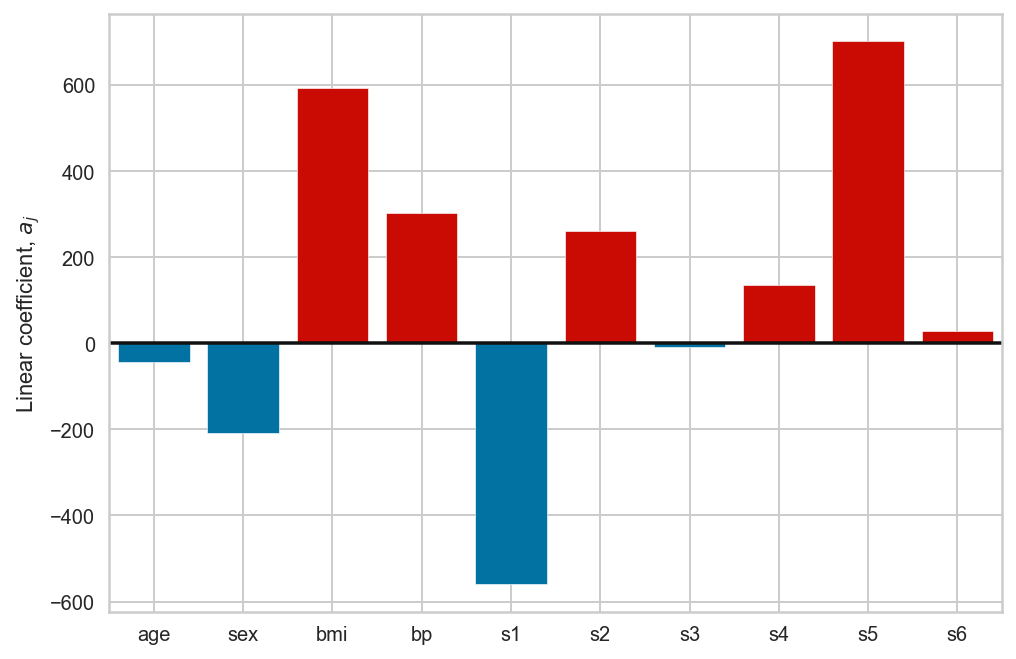

In [37]:
coefs = regressor.coef_
coefs_idx = np.arange(len(coefs))
pos_coefs = coefs > 0
neg_coefs = coefs < 0

fig, ax = plt.subplots()

ax.bar(coefs_idx[pos_coefs], coefs[pos_coefs], color='r')
ax.bar(coefs_idx[neg_coefs], coefs[neg_coefs], color='b')
ax.axhline(0, color='k')
ax.set_ylabel('Linear coefficient, $a_j$');
ax.set_xticks(coefs_idx)
ax.set_xticklabels(features)
ax.set_xlim(-0.5, coefs_idx.max()+0.5);

We can also check for sample outliers with [Cook's distance](https://www.scikit-yb.org/en/latest/api/regressor/influence.html), which measures the influence of each sample on the model fit: samples with a large influence on the fit are suspicious.

In [38]:
from yellowbrick.regressor import CooksDistance

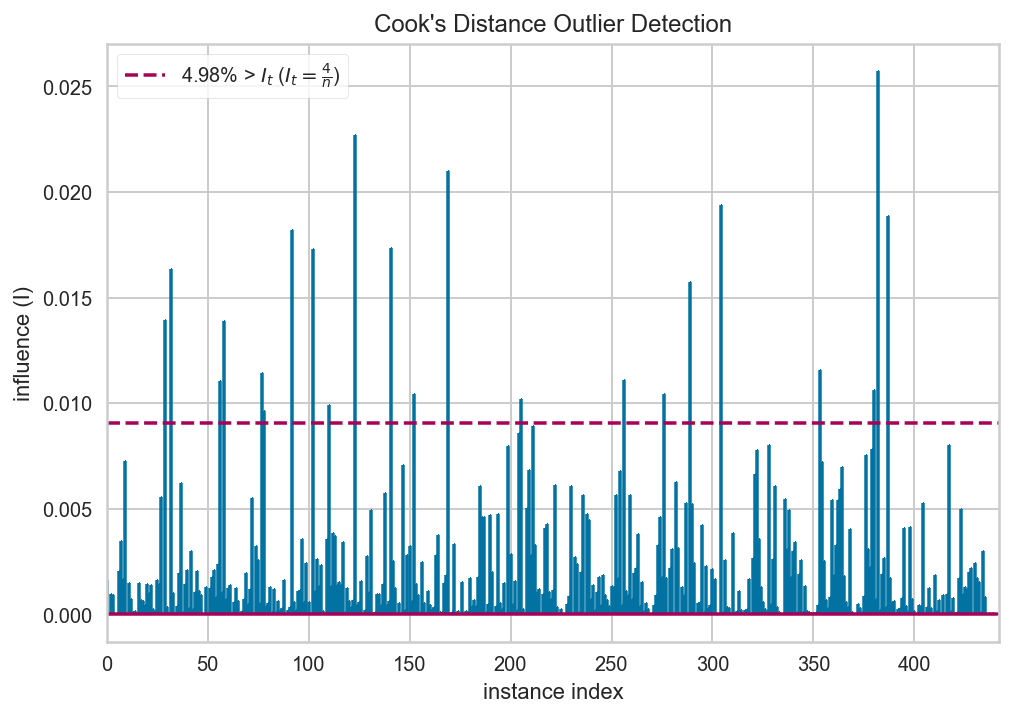

In [48]:
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show();

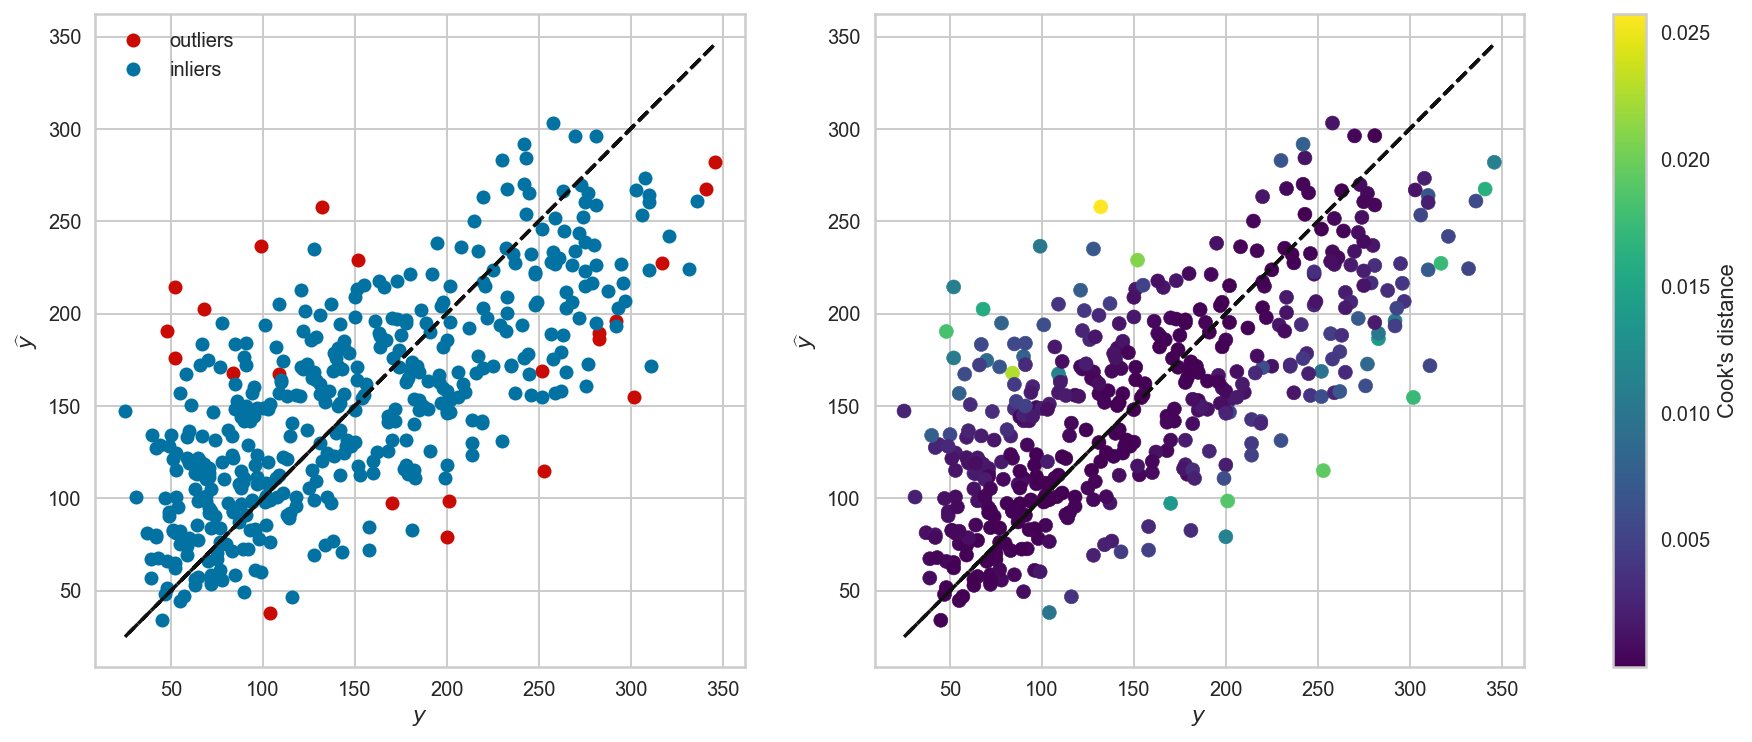

In [47]:
outliers = visualizer.distance_ > visualizer.influence_threshold_

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax = axes[0]
ax.plot(y[outliers], regressor.predict(X[outliers]), 'or', label='outliers')
ax.plot(y[~outliers], regressor.predict(X[~outliers]), 'ob', label='inliers')
ax.plot(y, y, '--k')
ax.set(xlabel='$y$', ylabel='$\widehat{y}$')
ax.legend()

ax = axes[1]
im = ax.scatter(y, regressor.predict(X), c=visualizer.distance_, cmap='viridis')
ax.plot(y, y, '--k')
ax.set(xlabel='$y$', ylabel='$\widehat{y}$')
plt.colorbar(im, ax=axes, label="Cook's distance");

## Exercise: Lasso

Now experiment with the Lasso model from the `linear_model` package ([Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)): least absolute shrinkage and selection operator).

Lasso is a linear model that performs _regularization_: avoiding giving too much weight to any single feature. 
This is done by minimizing not just the sum of residual squares between the model predictions and the observed values (the fit), but also the sum of the absolute values of the model coefficients (the penalty):

$$
\hat{y} = a_0 + a_1 x_1 + \ldots + a_m x_m \\
f(a_1, \ldots, a_m) = \frac{1}{2n} \sum_{i=1}^{n}{(\hat{y}_i - y_i)^2} + \alpha \sum_{j=1}^{m} |a_j|
$$

This is useful for feature selection, that is, finding features that are less important and therefore get a zero coefficeint. 
Thus, is increases prediction accuracy as well as interpretability of the linear model.

A meta-parameter $\alpha$ is used to weight the penalty relative to the fit: the higher $\alpha$, the more weight is given to the penalty.

**Repeat the analysis from above with a Lasso model**.

**Reminder**
- Edit cell by double clicking
- Run cell by pressing _Shift+Enter_
- Get autocompletion by pressing _Tab_
- Get documentation by pressing _Shift+Tab_

Lasso model score: 0.36


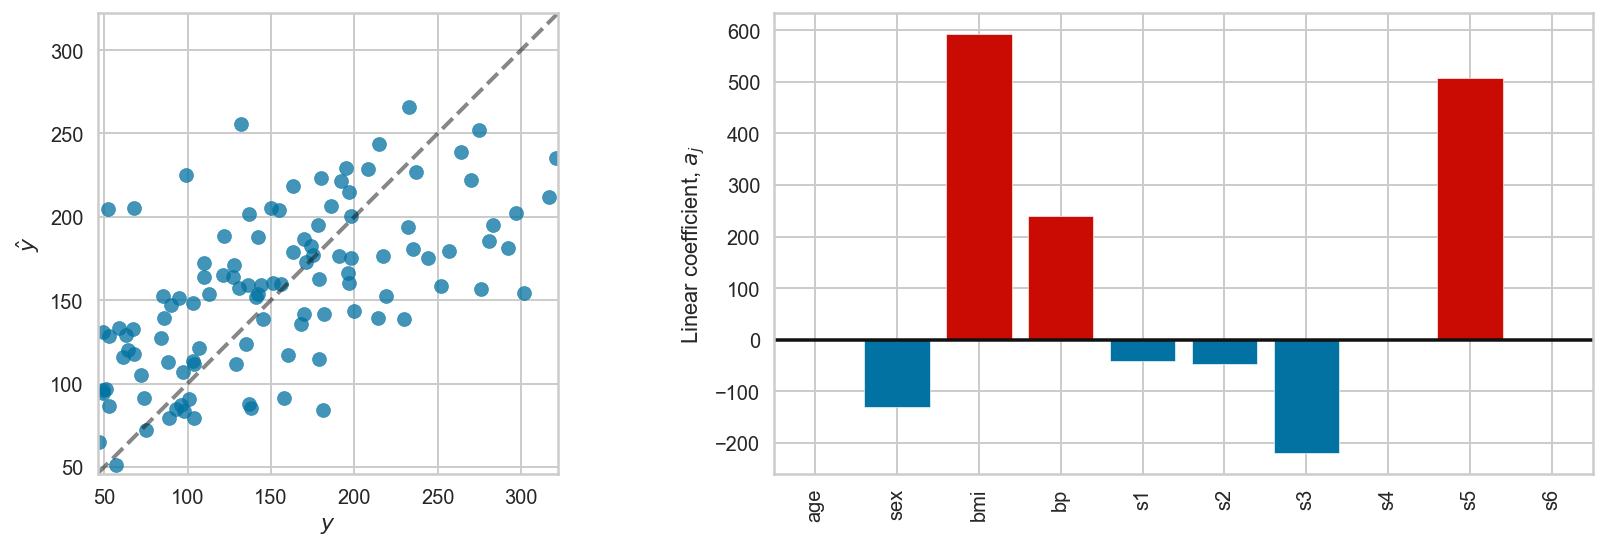

**Bonus**:
to avoid choosing your own $\alpha$, try the `LassoCV` model (from scikit-learn) with the `AlphaSelection` visualization (from yellowbrick).

LassoCV α: 0.087
LassoCV model score: 0.36


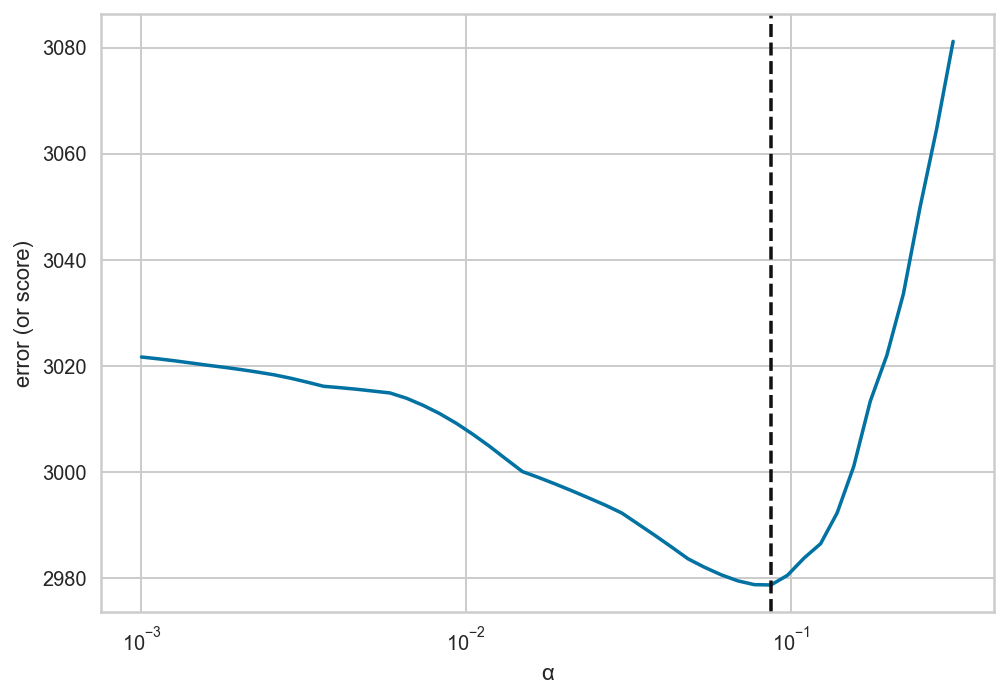

# References

- Scikit-learn [supervised learning tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html).
- [Tuning meta-parameters](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) with cross validation.

# Futher exercise

- [Regression with a linear model](../exercises/linear-model.ipynb)
- [Classification with a logistic model](../exercises/logistic-tennis.ipynb)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)